# 🧠 First-Visit Monte Carlo Prediction

## 📘 1. Introdução

O **método de predição Monte Carlo de primeira visita** (*First-Visit Monte Carlo Prediction*) é um algoritmo de **aprendizado por reforço** usado para **estimar a função de valor de estados $V(s)$** de uma política fixa $\pi$, **sem precisar conhecer o modelo do ambiente**.

Ele aprende a partir de episódios completos, ou seja, interações reais entre agente e ambiente, e estima os valores médios das recompensas recebidas.

## 🧩 2. Objetivo

O objetivo é estimar o **valor esperado de cada estado** $ s $ ao seguir uma política $ \pi $:

$$
V_\pi(s) = \mathbb{E}_\pi [G_t \mid S_t = s]
$$

onde:

- $ V_\pi(s) $: valor esperado do estado $ s $ sob a política $ \pi $;
- $G_t $: retorno total acumulado a partir do tempo $ t $:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}
$$

- $\gamma \in [0,1]$: fator de desconto, que pondera a importância das recompensas futuras;
- $R_t$: recompensa recebida na transição entre os estados;
- $\pi(a|s)$: política que define a probabilidade de escolher a ação $ a $ no estado $ s $.

## 🧮 3. Ideia principal do algoritmo

O método Monte Carlo calcula $V(s)$**a partir de amostras empíricas de retornos $G_t$** observadas em episódios completos.

Para cada episódio:

1. Gera uma sequência de interações até o estado terminal:
   
   $$
   S_0, A_0, R_1, S_1, A_1, R_2, ..., S_T
   $$


2. Calcula o retorno $ G_t $ de cada tempo $ t $:
   
   $$
   G_t = R_{t+1} + \gamma R_{t+2} + \dots
   $$   


3. Para cada **primeira visita** a um estado $ s $, atualiza a estimativa de $ V(s) $ como a **média dos retornos** observados:
   
   $$
   V(s) = \frac{1}{N(s)} \sum_{i=1}^{N(s)} G_i
   $$
   
   onde $N(s)$ é o número de primeiras visitas ao estado $ s$.

## 🔢 4. Fórmulas resumidas

| Símbolo | Significado |
|----------|-------------|
| $S_t$ | Estado no tempo $ t $ |
| $A_t$ | Ação no tempo $ t $ |
| $R_{t+1}$ | Recompensa após executar $ A_t $ |
| $\pi(a|s)$ | Política fixa |
| $\gamma$ | Fator de desconto |
| $G_t$ | Retorno acumulado desde $ t $ |
| $V(s)$ | Valor estimado do estado |
| $N(s)$ | Número de primeiras visitas a $ s $ |

## ⚙️ 5. Pseudocódigo do algoritmo

```text
A. Inicializar V(s) arbitrariamente   
B. Inicializar Returns(s) como lista vazia   

C. Para cada episódio:   
    C.1. Gerar um episódio seguindo a política π: S0, A0, R1, S1, ...   
    C.2. G ← 0   
    C.3. Para t = T-1 até 0:   
        C.3.1. G ← γ * G + R_{t+1}   
        C.3.2. Se St não ocorreu anteriormente no episódio:   
            C.3.2.1 Adicionar G a Returns(St)   
            C.3.2.2. V(St) ← média(Returns(St))
```

In [57]:
! pip install gymnasium

In [7]:
# Importações
from __future__ import annotations
import numpy as np
from collections import defaultdict
from typing import Callable, Dict, Tuple, List

In [8]:
# Tipagens
State = Tuple[int, int, bool]  # (player_sum, dealer_card, usable_ace)
Action = int                   # 0 = stick, 1 = hit
Policy = Callable[[State], Action]
ValueFunction = Dict[State, float]

## 🧩 6.1 Função generate_episode

Gera um episódio completo de interações com o ambiente seguindo uma política.

### Explicação:

- Usa o padrão da API moderna do Gymnasium `(reset() → (obs, info) e step() → (obs, reward, terminated, truncated, info))`.

- Armazena a sequência de tuplas (estado, recompensa, done, ação).

- Retorna o episódio completo e o índice do estado terminal T.

In [9]:
def generate_episode(env, policy: Policy):
    """Gera um episódio. Compatível com Gym e Gymnasium.
    Retorna: (trajectory, T)","""
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            # compatibiliza env.reset() -> (obs, info) ou obs
            reset_ret = env.reset()
            if isinstance(reset_ret, tuple) and len(reset_ret) >= 1:
                St = reset_ret[0]
            else:
                St = reset_ret
            Rt = None
            done = False
        else:
            step_ret = env.step(At)
            # gymnasium: (obs, reward, terminated, truncated, info)
            # gym (old): (obs, reward, done, info)
            if isinstance(step_ret, tuple) and len(step_ret) == 5:
                St, Rt, terminated, truncated, _ = step_ret
                done = bool(terminated or truncated)
            elif isinstance(step_ret, tuple) and len(step_ret) == 4:
                St, Rt, done, _ = step_ret
            elif isinstance(step_ret, tuple) and len(step_ret) == 3:
                St, Rt, done = step_ret
            else:
                # fallback
                St, Rt, done = step_ret[0], step_ret[1], step_ret[2]

        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:
            break

    return trajectory, len(trajectory) - 1

### ⚙️ 6.2 Função first_visit_MC_prediction

Executa o algoritmo principal de Monte Carlo.

Explicação passo a passo

| Linha                           | Função                                                  | Descrição |
| ------------------------------- | ------------------------------------------------------- | --------- |
| `Returns`                       | Armazena listas de retornos observados para cada estado |           |
| `generate_episode`              | Gera um episódio completo                               |           |
| `for t in range(T-1, -1, -1)`   | Percorre o episódio de trás para frente                 |           |
| `G = gamma * G + Rt_1`          | Calcula o retorno acumulado com desconto                |           |
| `if St not in [traj[i][0] ...]` | Verifica se é a **primeira visita**                     |           |
| `V[St] = np.mean(Returns[St])`  | Atualiza o valor médio estimado                         |           |


In [10]:
def first_visit_MC_prediction(env, policy: Policy, episodes: int = 10000, gamma: float = 1.0):
    Returns = defaultdict(list)
    V: ValueFunction = {}

    for ep in range(episodes):
        traj, T = generate_episode(env, policy)
        G = 0.0
        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])
    return V

## 🃏 6.3 Política de Blackjack

Política determinística simples usada para avaliação.

Explicação:

- O jogador para (ação 0) se a soma ≥ 20;

- Caso contrário, pede carta (ação 1).

In [11]:
def policy_blackjack(state: State) -> Action:
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1

# 📊 7. Visualização dos resultados   
## 🗺️ 7.1 Mapa de calor dos valores

Mostra o valor esperado $V(s)$ para diferentes estados.
Interpretação:

Cada célula mostra o valor esperado 

- O gráfico da esquerda representa estados com Ás “usável”.

- O da direita, estados sem Ás “usável”

In [12]:
def value_to_array(V: ValueFunction, usable_ace: bool) -> np.ndarray:
    Vd = defaultdict(float, V)
    arr = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            arr[player_sum - 12, dealer_card - 1] = Vd[(player_sum, dealer_card, usable_ace)]
    return arr

In [18]:
# Plotting utilities (to be executed interactively in the notebook)
# import matplotlib.pyplot as plt

def plot_value_heatmap(V, title_prefix: str = ""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, usable_ace in zip(axes, [True, False]):
        data = value_to_array(V, usable_ace)
        im = ax.imshow(data, cmap='viridis', origin='lower', extent=[1, 10, 12, 21], aspect='auto')
        ax.set_title(f"{title_prefix}Usable Ace = {usable_ace}")
        ax.set_xlabel("Dealer Mostrando")
        ax.set_ylabel("Player Soma")
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

## 📈 7.2 Gráfico de convergência

Mostra como a média dos valores $V(s)$ converge à medida que o número de episódios aumenta.

Interpretação:

- O eixo X mostra o número de episódios simulados.
- O eixo Y mostra o valor médio absoluto dos estados.

A estabilização da curva indica convergência.

In [19]:
def plot_convergence(env, policy, episodes: int = 30000, gamma: float = 1.0):
    V = {}
    Returns = defaultdict(list)
    avg_values = []

    for ep in range(episodes):
        traj, T = generate_episode(env, policy)
        G = 0.0
        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])
        avg_values.append(np.mean(list(map(abs, V.values()))) if V else 0)

    plt.figure(figsize=(8, 5))
    plt.plot(avg_values)
    plt.title("Convergência do valor médio |V(s)|")
    plt.xlabel("Episódios")
    plt.ylabel("Valor médio absoluto")
    plt.grid(True)
    plt.show()

    return V



```text
[Início]
   ↓
Gerar episódio → (S0, A0, R1, S1, ...)
   ↓
Calcular retornos G_t para cada t
   ↓
Para cada primeira visita a S_t:
     Atualizar média de V(S_t)
   ↓
Repetir por N episódios
   ↓
[Obter estimativas estáveis V(s)]

```

In [24]:
# Exemplo de uso (executar interativamente)
# Requisitos: gymnasium (ou gym), numpy, matplotlib
# ! pip install gymnasium

try:
    import gymnasium as gym
    env = gym.make('Blackjack-v1')
except Exception:
    import gym
    env = gym.make('Blackjack-v0')

# Rodar a predição (pode demorar dependendo do número de episódios)
V = first_visit_MC_prediction(env, policy_blackjack, episodes=20000, gamma=1.0)

In [25]:
list(V.keys())

[(13, 9, 0),
 (20, 1, 0),
 (18, 6, 0),
 (15, 6, 0),
 (21, 1, 0),
 (16, 1, 0),
 (14, 1, 0),
 (16, 6, 0),
 (20, 10, 0),
 (21, 5, 0),
 (15, 5, 0),
 (18, 5, 1),
 (7, 5, 0),
 (16, 3, 0),
 (18, 3, 1),
 (21, 3, 1),
 (13, 3, 1),
 (12, 6, 0),
 (17, 5, 0),
 (14, 7, 0),
 (21, 4, 0),
 (19, 4, 0),
 (13, 4, 0),
 (13, 10, 0),
 (20, 3, 0),
 (19, 3, 0),
 (14, 10, 0),
 (7, 10, 0),
 (21, 1, 1),
 (17, 10, 0),
 (12, 5, 0),
 (18, 10, 0),
 (21, 10, 1),
 (17, 10, 1),
 (18, 7, 0),
 (12, 7, 0),
 (19, 10, 0),
 (15, 10, 0),
 (21, 7, 0),
 (19, 7, 0),
 (12, 8, 0),
 (21, 4, 1),
 (10, 4, 0),
 (17, 1, 0),
 (20, 7, 0),
 (19, 7, 1),
 (21, 2, 1),
 (11, 10, 0),
 (9, 4, 0),
 (20, 6, 0),
 (17, 6, 0),
 (7, 6, 0),
 (19, 8, 0),
 (13, 8, 0),
 (20, 9, 0),
 (14, 9, 0),
 (18, 2, 0),
 (13, 2, 0),
 (13, 2, 1),
 (21, 2, 0),
 (15, 2, 0),
 (10, 2, 0),
 (15, 1, 0),
 (5, 8, 0),
 (15, 6, 1),
 (21, 6, 1),
 (13, 1, 0),
 (12, 10, 0),
 (12, 10, 1),
 (10, 6, 0),
 (17, 2, 0),
 (19, 10, 1),
 (16, 10, 1),
 (21, 9, 0),
 (11, 9, 0),
 (16, 2, 0),
 (

In [17]:
# Mostrar heatmap
plot_value_heatmap(V, title_prefix='Blackjack - ')

{(14, 5, 0): -0.6293706293706294,
 (17, 9, 0): -0.7216828478964401,
 (18, 8, 0): -0.6987577639751553,
 (12, 8, 0): -0.5490196078431373,
 (21, 6, 0): 0.9073359073359073,
 (16, 6, 0): -0.5816618911174785,
 (15, 6, 0): -0.5683229813664596,
 (18, 5, 0): -0.7353846153846154,
 (16, 5, 0): -0.7115384615384616,
 (20, 2, 0): 0.6610978520286396,
 (17, 2, 0): -0.7275747508305648,
 (11, 2, 0): -0.043478260869565216,
 (21, 8, 1): 0.9695121951219512,
 (20, 2, 1): 0.7111111111111111,
 (12, 10, 0): -0.5707720588235294,
 (19, 9, 0): -0.7689969604863222,
 (15, 9, 0): -0.6209150326797386,
 (10, 9, 0): 0.048,
 (12, 6, 0): -0.5392857142857143,
 (19, 6, 1): -0.36666666666666664,
 (15, 1, 0): -0.6959706959706959,
 (13, 2, 0): -0.6112956810631229,
 (17, 10, 0): -0.7402078337330136,
 (9, 10, 0): -0.5331491712707183,
 (5, 10, 0): -0.5254237288135594,
 (21, 10, 1): 0.9204152249134948,
 (20, 8, 0): 0.7933491686460807,
 (17, 7, 0): -0.696875,
 (21, 4, 1): 0.9785714285714285,
 (19, 4, 1): -0.21052631578947367,
 (13

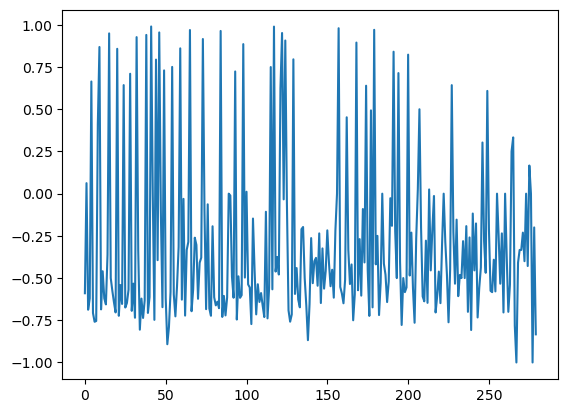

In [29]:
plt.plot(list(V.values()))

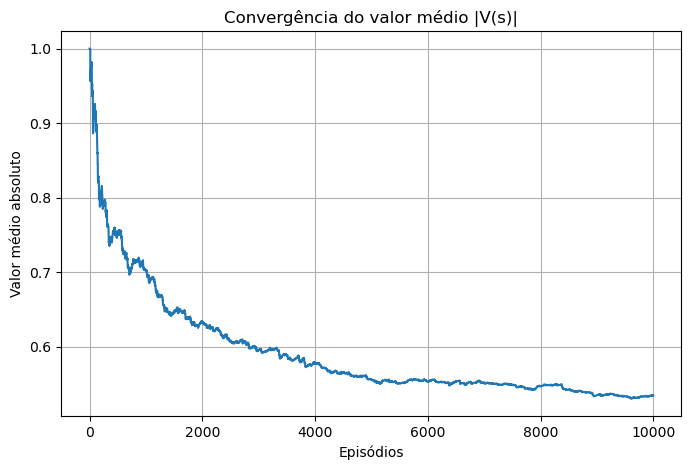

In [44]:
# Mostrar convergência (ex.: 30000 episódios)
V_1 = plot_convergence(env, policy_blackjack, episodes=10000, gamma=1.0)

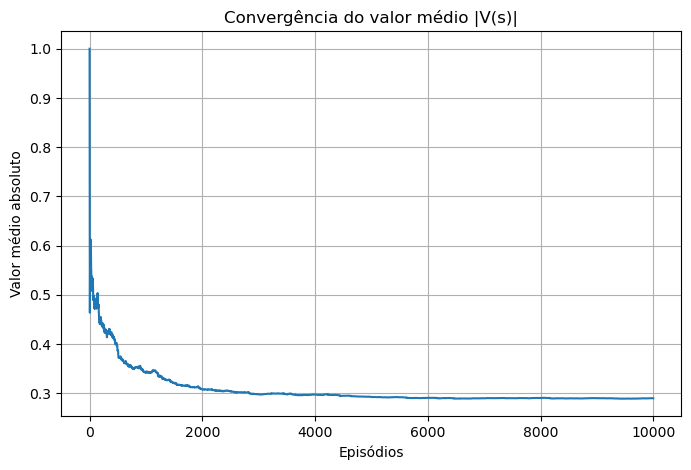

In [45]:
V_01 = plot_convergence(env, policy_blackjack, episodes=10000, gamma=0.1)

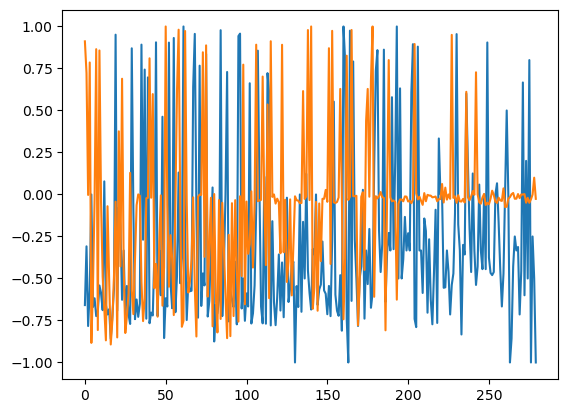

In [46]:
plt.plot(list(V_1.values()))
plt.plot(list(V_01.values()))

In [47]:
len(V_01)

280

In [48]:
len(V_1)

280

# 🧩 Política aprimorada — Heuristic Policy

| Situação                                   | Decisão                                            | Racional                            |
| ------------------------------------------ | -------------------------------------------------- | ----------------------------------- |
| **Com Ás utilizável**                      | Pode “arriscar” mais, pois o Ás pode valer 1 ou 11 | Flexibilidade reduz o risco de bust |
| **Sem Ás utilizável**                      | Parar mais cedo                                    | Qualquer carta alta pode estourar   |
| **Dealer mostrando carta alta (7–10, Ás)** | Jogador deve ser mais agressivo                    | Dealer tem vantagem potencial       |
| **Dealer mostrando carta baixa (2–6)**     | Jogador pode esperar                               | Alta chance do dealer estourar      |

In [50]:
def policy_blackjack_advanced(state: tuple[int, int, bool]) -> int:
    """
    Política heurística mais sofisticada para o Blackjack.
    Retorna:
      0 -> stick (parar)
      1 -> hit   (pedir carta)
    """
    player_sum, dealer_card, usable_ace = state

    # Estratégia mais prudente se há um Ás usável (flexibilidade maior)
    if usable_ace:
        if player_sum >= 19:
            return 0  # parar com 19 ou mais
        elif 17 <= player_sum <= 18:
            return 0 if dealer_card <= 8 else 1  # depende da carta do dealer
        else:
            return 1  # pedir abaixo de 17
    else:
        # Sem Ás utilizável, risco de estourar é maior
        if player_sum >= 17:
            return 0  # parar com 17 ou mais
        elif 13 <= player_sum <= 16:
            # se o dealer tem carta alta (7 ou mais), é mais seguro pedir
            return 1 if dealer_card >= 7 else 0
        elif player_sum == 12:
            # só parar se dealer mostrar carta fraca (4, 5, 6)
            return 0 if 4 <= dealer_card <= 6 else 1
        else:
            return 1  # pedir sempre com 11 ou menos


Política simples vs. avançada


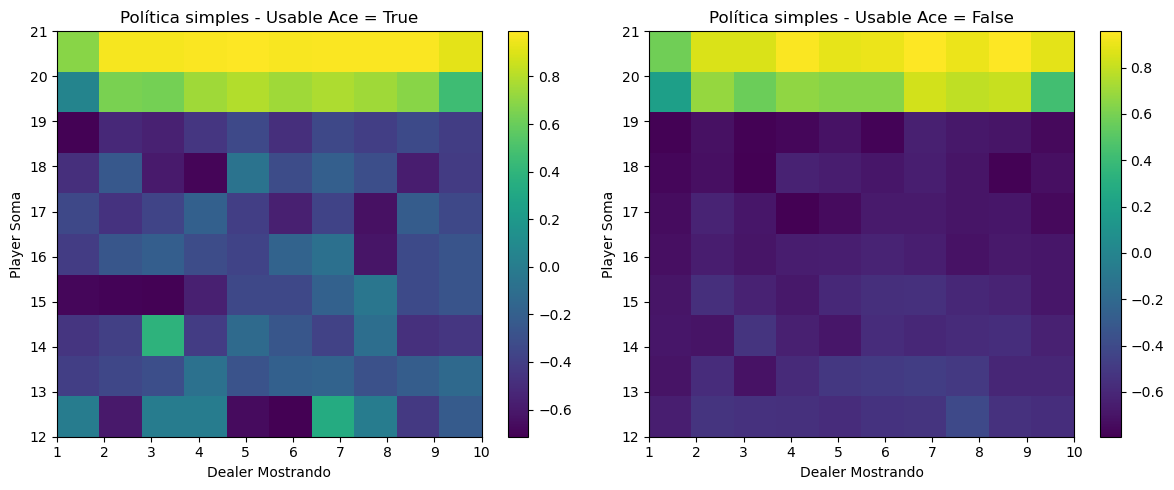

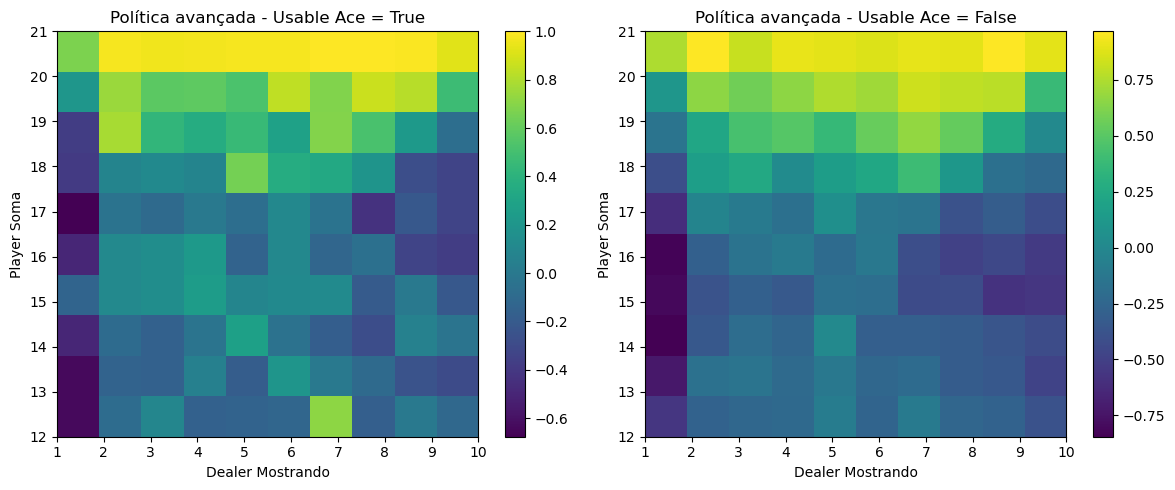

In [51]:
# Comparar políticas
V_simple = first_visit_MC_prediction(env, policy_blackjack, episodes=20000, gamma=1.0)
V_advanced = first_visit_MC_prediction(env, policy_blackjack_advanced, episodes=20000, gamma=1.0)

# Visualizar lado a lado
print("Política simples vs. avançada")
plot_value_heatmap(V_simple, title_prefix="Política simples - ")
plot_value_heatmap(V_advanced, title_prefix="Política avançada - ")

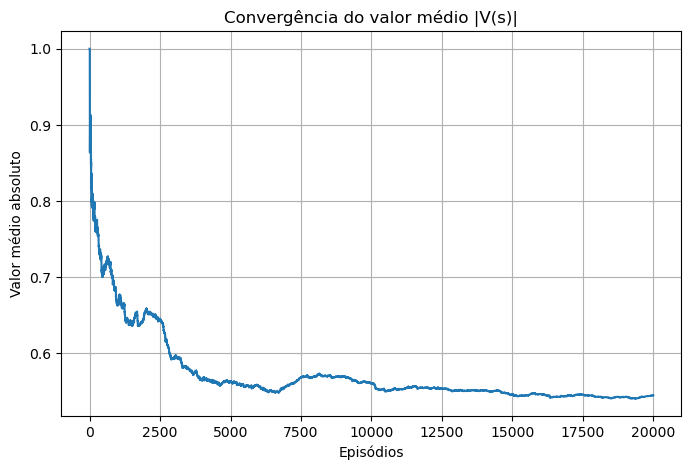

{(21, 10, 1): 0.9005376344086021,
 (10, 10, 0): -0.14666666666666667,
 (14, 6, 0): -0.6,
 (18, 7, 0): -0.6939655172413793,
 (10, 7, 0): -0.1,
 (19, 9, 0): -0.6807692307692308,
 (16, 9, 0): -0.6697247706422018,
 (15, 9, 0): -0.5124378109452736,
 (21, 10, 0): 0.8896103896103896,
 (14, 10, 0): -0.6373056994818653,
 (5, 10, 0): -0.3333333333333333,
 (20, 7, 0): 0.7574750830564784,
 (15, 7, 0): -0.5747663551401869,
 (14, 7, 0): -0.5534883720930233,
 (14, 4, 0): -0.7100591715976331,
 (20, 3, 0): 0.6327272727272727,
 (20, 9, 0): 0.7649122807017544,
 (10, 9, 0): -0.09876543209876543,
 (13, 2, 0): -0.5969387755102041,
 (18, 9, 0): -0.6933333333333334,
 (14, 9, 0): -0.5533980582524272,
 (15, 10, 0): -0.6426767676767676,
 (17, 4, 0): -0.7670454545454546,
 (19, 4, 1): -0.1111111111111111,
 (18, 3, 0): -0.7319148936170212,
 (20, 5, 0): 0.6405228758169934,
 (18, 5, 0): -0.7709251101321586,
 (12, 7, 0): -0.5728643216080402,
 (15, 6, 0): -0.6666666666666666,
 (5, 6, 0): -0.42105263157894735,
 (19, 6, 

In [55]:
plot_convergence(env, policy_blackjack, episodes=20000, gamma=1.0)

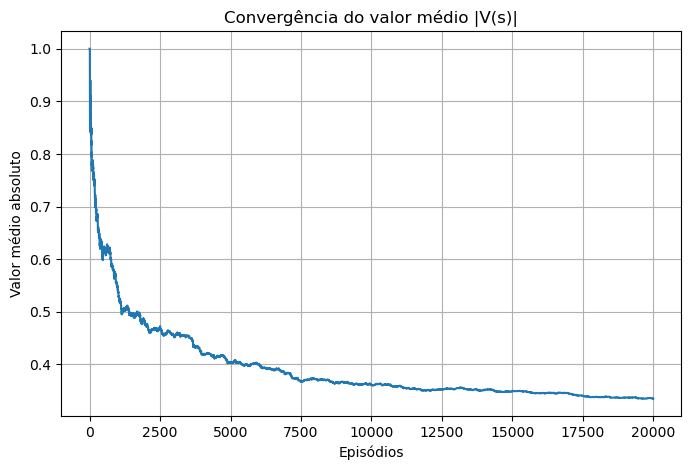

{(19, 10, 0): -0.0014534883720930232,
 (14, 10, 0): -0.5757978723404256,
 (19, 7, 0): 0.6055555555555555,
 (12, 7, 0): -0.2553191489361702,
 (20, 1, 0): 0.04784688995215311,
 (21, 10, 0): 0.8609625668449198,
 (12, 10, 0): -0.4148471615720524,
 (13, 10, 0): -0.48365122615803813,
 (18, 5, 0): 0.14925373134328357,
 (19, 1, 0): -0.10743801652892562,
 (17, 9, 0): -0.4727272727272727,
 (12, 9, 0): -0.31976744186046513,
 (8, 10, 0): -0.359375,
 (21, 7, 0): 0.9108910891089109,
 (11, 7, 0): 0.3157894736842105,
 (18, 8, 0): 0.07211538461538461,
 (15, 5, 0): -0.013157894736842105,
 (18, 6, 0): 0.41818181818181815,
 (12, 6, 0): -0.05952380952380952,
 (9, 10, 0): -0.3125,
 (16, 8, 0): -0.44329896907216493,
 (16, 8, 1): 0.0,
 (5, 8, 0): -0.13636363636363635,
 (15, 2, 0): -0.2692307692307692,
 (15, 2, 1): -0.08695652173913043,
 (20, 5, 0): 0.7215189873417721,
 (17, 7, 0): -0.1590909090909091,
 (15, 3, 0): -0.25333333333333335,
 (18, 3, 0): 0.06,
 (21, 9, 1): 0.9885057471264368,
 (14, 8, 0): -0.340101

In [56]:
plot_convergence(env, policy_blackjack_advanced, episodes=20000, gamma=1.0)